## Классификация звуков на PyTorch

Этот ноутбук представляет собой практическое исследование трех различных подходов к задаче классификации звуков на примере набора данных [ESC-50](https://github.com/karolpiczak/ESC-50).

**Будут рассмотрены и сравнены следующие методы:**

1.  **Классическая сверточная нейронная сеть (CNN) на Мел-спектрограммах:**
    *   Использование предобученной модели ResNet18, адаптированной для анализа спектрограмм.
    *   Применение как волновых, так и спектральных аугментаций для увеличения разнообразия обучающих данных.
2.  **Эмбеддинги из PANNs (Pre-trained Audio Neural Networks) + MLP:**
    *   Извлечение высокоуровневых признаков (эмбеддингов) из аудио с помощью мощной предобученной модели PANNs.
    *   Обучение простого многослойного перцептрона (MLP) на этих эмбеддингах для классификации.
3.  **Audio Spectrogram Transformer (AST):**
    *   Тонкая настройка (fine-tuning) современной трансформерной архитектуры, специально разработанной для задач аудиоанализа, на целевых классах.
    *   Использование специфичных для AST аугментаций и методов подготовки данных.

---

In [ ]:
!pip install -q torchaudio transformers pytorch_lightning seaborn panns-inference audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/karolpiczak/ESC-50.git
!ls ESC-50/meta ESC-50/audio | head

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.
ESC-50/audio:
1-100032-A-0.wav
1-100038-A-14.wav
1-100210-A-36.wav
1-100210-B-36.wav
1-101296-A-19.wav
1-101296-B-19.wav
1-101336-A-30.wav
1-101404-A-34.wav
1-103298-A-9.wav


In [ ]:
import os, random
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, FrequencyMasking, TimeMasking, Resample
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torchvision.models import resnet18
import math
import torch.nn as nn
import IPython.display as ipd
import time

# Параметры задания
CLASSES = ['dog', 'cat']        # целевые классы
NUM_VAL     = 5                 # примеров на класс в val
NUM_TRAIN = 15                  # исходных примеров на класс
TARGET_SIZE = 50                # после аугментации
SR = 16000                      # частота дискретизации
DURATION = 5                    # длительность в секундах
SAMPLES = SR * DURATION         # число сэмплов
BATCH_SIZE = 8                  # размер батча
LR = 1e-4                       # learning rate
EPOCHS = 10                     # число эпох
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, snr_db=15, p=0.5):
        super().__init__()
        self.snr_db = snr_db
        self.p = p

    def forward(self, waveform):
        if torch.rand(1) < self.p:
            signal_power = waveform.norm(p=2)
            noise = torch.randn_like(waveform)
            noise_power = noise.norm(p=2)
            snr = 10**(self.snr_db / 10)
            scale = (signal_power / (noise_power * snr)).sqrt()
            return waveform + scale * noise
        return waveform
class RandomVolume(nn.Module):
    def __init__(self, min_gain_db=-6, max_gain_db=6, p=0.5):
        super().__init__()
        self.min_gain_db = min_gain_db
        self.max_gain_db = max_gain_db
        self.p = p

    def forward(self, waveform):
        if random.random() < self.p:
            gain_db = random.uniform(self.min_gain_db, self.max_gain_db)
            gain_factor = 10 ** (gain_db / 20)
            gain_factor = max(gain_factor, 1e-5)
            return waveform * gain_factor
        return waveform

In [ ]:
# 1. Waveform-аугментации (применяются к исходному аудио)
waveform_augment = nn.Sequential(
    RandomVolume(min_gain_db=-6, max_gain_db=6, p=0.5),
    GaussianNoise(snr_db=30, p=0.5),
)

# 2. Преобразование в спектрограмму
spec_transform = nn.Sequential(
    MelSpectrogram(sample_rate=SR, n_fft=1024, hop_length=512, n_mels=128),
    AmplitudeToDB()
)

# 3. Спектральные аугментации (применяются к спектрограммам)
spec_augment = {
    "waveform": waveform_augment,
    "spec": nn.Sequential(
        TimeMasking(time_mask_param=5),
        FrequencyMasking(freq_mask_param=5)
    )
}
MAX_FRAMES = math.ceil(SAMPLES / 512)

In [ ]:
def prepare_audio(wav, sr):
    wav = wav.mean(dim=0, keepdim=True)
    if sr != SR:
        wav = torchaudio.transforms.Resample(sr, SR)(wav)
    if wav.size(1) > SAMPLES:
        wav = wav[:, :SAMPLES]
    else:
        pad_size = SAMPLES - wav.size(1)
        wav = nn.functional.pad(wav, (0, pad_size))
    return wav

def to_spectrogram(wav):
    spec = spec_transform(wav)
    if spec.size(2) > MAX_FRAMES:
        spec = spec[:, :, :MAX_FRAMES]
    else:
        pad = MAX_FRAMES - spec.size(2)
        spec = nn.functional.pad(spec, (0, pad))
    return spec

def compare_two_classes_wav(class_a_path, class_b_path):
    wav_a, sr_a = torchaudio.load(class_a_path)
    wav_b, sr_b = torchaudio.load(class_b_path)

    wav_a_orig = prepare_audio(wav_a, sr_a)
    wav_b_orig = prepare_audio(wav_b, sr_b)

    if spec_augment and "waveform" in spec_augment:
        wav_a_aug = spec_augment["waveform"](wav_a_orig.clone())
        wav_b_aug = spec_augment["waveform"](wav_b_orig.clone())
    else:
        wav_a_aug = wav_a_orig.clone()
        wav_b_aug = wav_b_orig.clone()

    spec_a_orig = to_spectrogram(wav_a_orig)
    spec_b_orig = to_spectrogram(wav_b_orig)
    spec_a_aug = to_spectrogram(wav_a_aug)
    spec_b_aug = to_spectrogram(wav_b_aug)

    if spec_augment and "spec" in spec_augment:
        spec_a_aug = spec_augment["spec"](spec_a_aug)
        spec_b_aug = spec_augment["spec"](spec_b_aug)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0,0].imshow(spec_a_orig[0].numpy(), origin='lower', aspect='auto')
    axs[0,0].set_title("Class A (Original)")
    axs[0,1].imshow(spec_a_aug[0].numpy(), origin='lower', aspect='auto')
    axs[0,1].set_title("Class A (Augmented)")

    axs[1,0].imshow(spec_b_orig[0].numpy(), origin='lower', aspect='auto')
    axs[1,0].set_title("Class B (Original)")
    axs[1,1].imshow(spec_b_aug[0].numpy(), origin='lower', aspect='auto')
    axs[1,1].set_title("Class B (Augmented)")

    plt.tight_layout()
    plt.show()

    print("Class A Original Audio:")
    ipd.display(ipd.Audio(wav_a_orig.squeeze().numpy(), rate=SR))
    print("Class A Augmented Audio:")
    ipd.display(ipd.Audio(wav_a_aug.squeeze().numpy(), rate=SR))

    print("\nClass B Original Audio:")
    ipd.display(ipd.Audio(wav_b_orig.squeeze().numpy(), rate=SR))
    print("Class B Augmented Audio:")
    ipd.display(ipd.Audio(wav_b_aug.squeeze().numpy(), rate=SR))


### Проверяем как работают аугментации

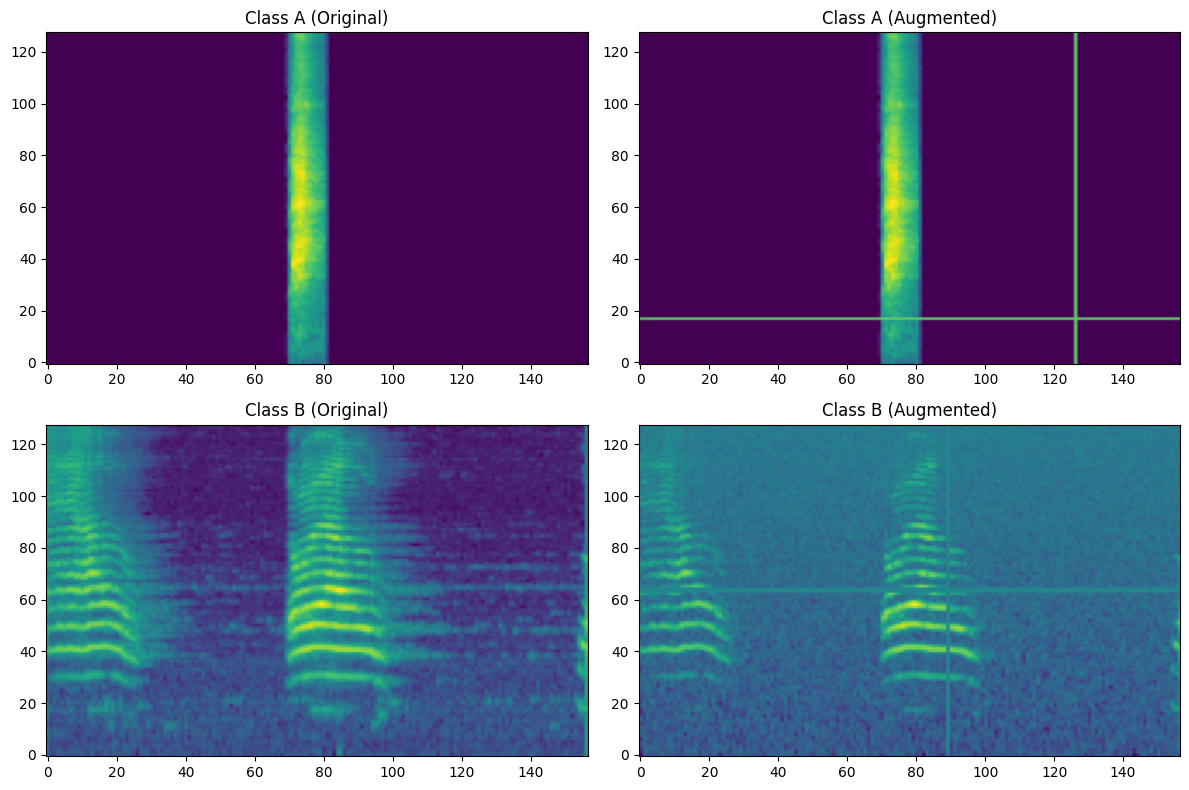

Class A Original Audio:


Class A Augmented Audio:



Class B Original Audio:


Class B Augmented Audio:


In [ ]:
class_a_audio = "/content/ESC-50/audio/1-100032-A-0.wav"
class_b_audio = "/content/ESC-50/audio/2-69131-A-5.wav"
compare_two_classes_wav(class_a_audio, class_b_audio)

In [ ]:
meta = pd.read_csv('ESC-50/meta/esc50.csv')
meta = meta[meta['category'].isin(CLASSES)]
files_by_class = {
    cls: meta[meta['category'] == cls]['filename'].tolist()
    for cls in CLASSES
}

train_files = {}
val_files   = {}
test_files  = {}
for cls, flist in files_by_class.items():
    random.shuffle(flist)
    train_files[cls] = flist[:NUM_TRAIN]
    val_files[cls]   = flist[NUM_TRAIN:NUM_TRAIN + NUM_VAL]
    test_files[cls]  = flist[NUM_TRAIN + NUM_VAL:]

In [ ]:
def get_train_files_dimensionality(train_files):
  num_classes = len(train_files)
  files_per_class = len(train_files[list(train_files.keys())[0]])
  total_files = num_classes * files_per_class
  return num_classes, files_per_class, total_files


print("\nTrain:")
num_classes, files_per_class, total_files = get_train_files_dimensionality(train_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")

print("\nValidation")
num_classes, files_per_class, total_files = get_train_files_dimensionality(val_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")

print("\nTest")
num_classes, files_per_class, total_files = get_train_files_dimensionality(test_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")


Train:
Number of classes: 2
Number of files per class: 15
Total number of training files: 30

Validation
Number of classes: 2
Number of files per class: 5
Total number of training files: 10

Test
Number of classes: 2
Number of files per class: 20
Total number of training files: 40


In [ ]:
class ESC50Split(Dataset):
    def __init__(self, files_dict, audio_dir,
                 spec_transform, spec_augment=None, target_size=None):
        """
        files_dict: {class_name: [fname, …]}
        spec_transform: callable – MelSpectrogram→dB
        spec_augment: dict или None – {"waveform": аугм., "spec": аугм.}
        target_size: int or None – для train: увеличить до target_size примеров на класс
        """
        self.audio_dir   = audio_dir
        self.spec_transform = spec_transform
        self.spec_augment   = spec_augment
        self.target_size    = target_size
        self.samples = []

        for cls, flist in files_dict.items():
            label = CLASSES.index(cls)
            if target_size is not None:
                base = random.sample(flist, min(len(flist), NUM_TRAIN))
                for i in range(target_size):
                    fname = base[i % len(base)]
                    self.samples.append((fname, label))
            else:
                for fname in flist:
                    self.samples.append((fname, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, label = self.samples[idx]
        path = os.path.join(self.audio_dir, fname)
        wav, sr = torchaudio.load(path)
        wav = wav.mean(dim=0, keepdim=True)

        if sr != SR:
            wav = Resample(sr, SR)(wav)

        if self.spec_augment and "waveform" in self.spec_augment:
            wav = self.spec_augment["waveform"](wav)

        if wav.size(1) > SAMPLES:
            wav = wav[:, :SAMPLES]
        else:
            pad = SAMPLES - wav.size(1)
            wav = nn.functional.pad(wav, (0, pad))

        spec = self.spec_transform(wav)

        if self.spec_augment and "spec" in self.spec_augment:
            spec = self.spec_augment["spec"](spec)

        if spec.size(2) > MAX_FRAMES:
            spec = spec[:, :, :MAX_FRAMES]
        else:
            pad = MAX_FRAMES - spec.size(2)
            spec = nn.functional.pad(spec, (0, pad))

        return spec, label

## Подход 1: CNN на спектрограммах + ResNet18

In [ ]:
train_ds = ESC50Split(
    train_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=spec_augment,
    target_size=TARGET_SIZE
)

val_ds = ESC50Split(
    val_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=None,
    target_size=None
)
test_ds = ESC50Split(
    test_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=None,
    target_size=None
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Количество файлов в train_ds:", len(train_ds))
print("Количество файлов в val_ds:", len(val_ds))
print("Количество файлов в test_ds:", len(test_ds))

Количество файлов в train_ds: 100
Количество файлов в val_ds: 10
Количество файлов в test_ds: 40


In [ ]:
model1 = resnet18(pretrained=True)
model1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model1.fc = nn.Linear(model1.fc.in_features, len(CLASSES))
model1 = model1.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [ ]:
def train_eval(model, train_loader, val_loader, epochs, lr, plot_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_acc': []}

    plt.figure(figsize=(12, 5))

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        preds, labs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE)
                out = model(x).argmax(1).cpu().tolist()
                preds += out
                labs += y.tolist()

        val_acc = accuracy_score(labs, preds)
        history['val_acc'].append(val_acc)

        if (ep+1) % plot_every == 0 or ep == 0:
            plt.clf()

            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], 'b-o', label='Train Loss')
            plt.title(f'Epoch {ep+1}/{epochs}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history['val_acc'], 'r-s', label='Val Accuracy')
            plt.title(f'Val Accuracy: {val_acc:.4f}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1.0)
            plt.grid(True)

            plt.tight_layout()
            plt.show()
            plt.pause(0.1)

        print(f"[Epoch {ep+1}/{epochs}] "
              f"train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")

    return history

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.062 ГБ памяти зарезервировано.


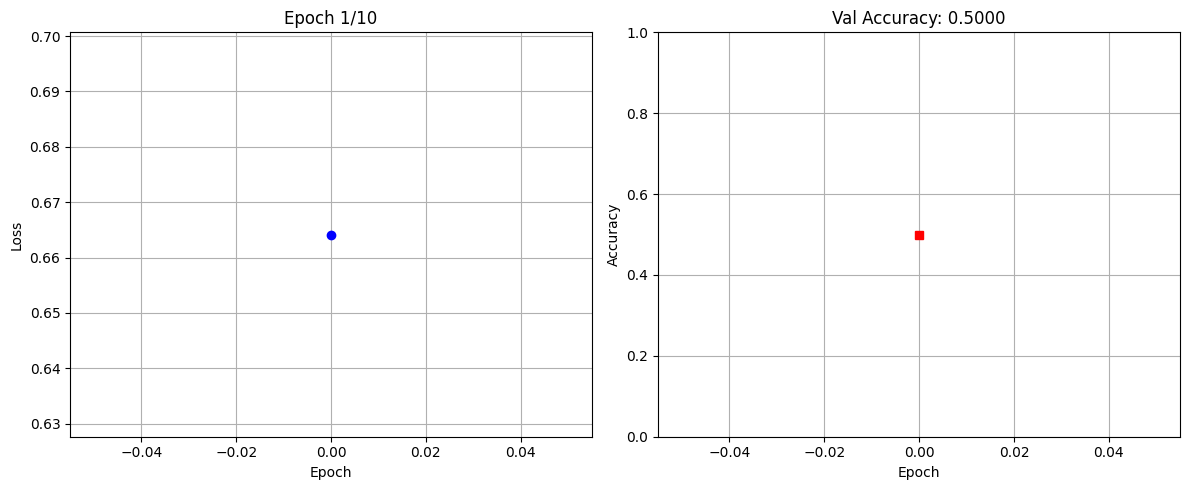

[Epoch 1/10] train_loss=0.6642  val_acc=0.5000


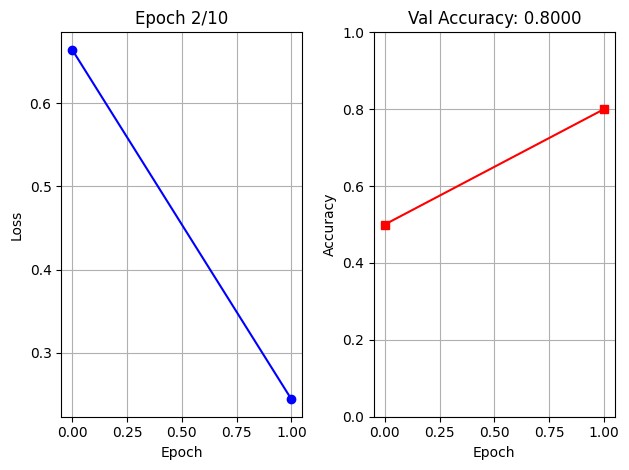

[Epoch 2/10] train_loss=0.2444  val_acc=0.8000


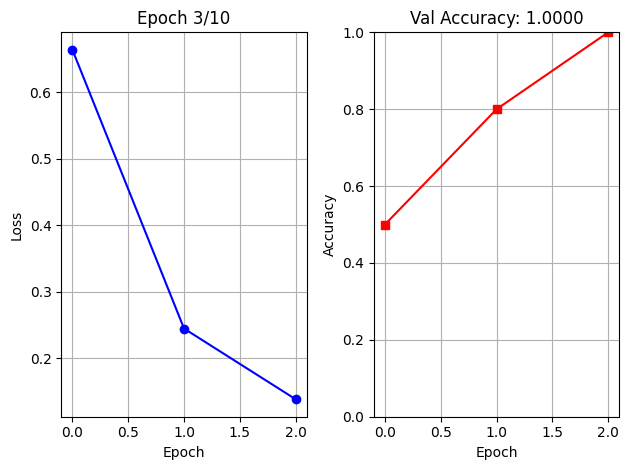

[Epoch 3/10] train_loss=0.1379  val_acc=1.0000


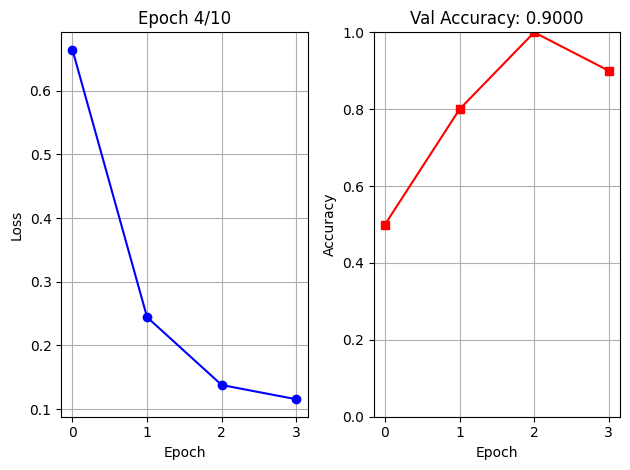

[Epoch 4/10] train_loss=0.1156  val_acc=0.9000


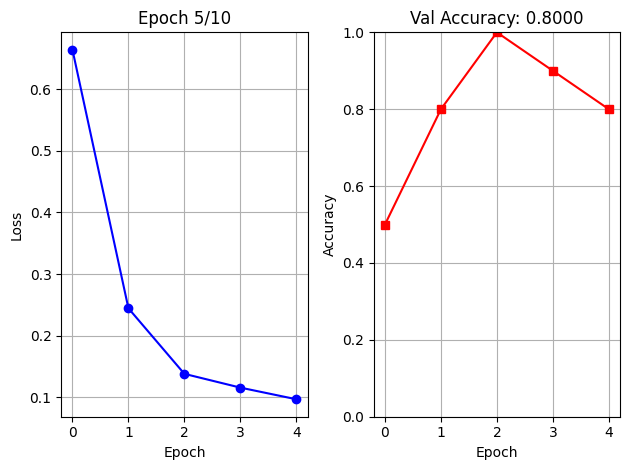

[Epoch 5/10] train_loss=0.0967  val_acc=0.8000


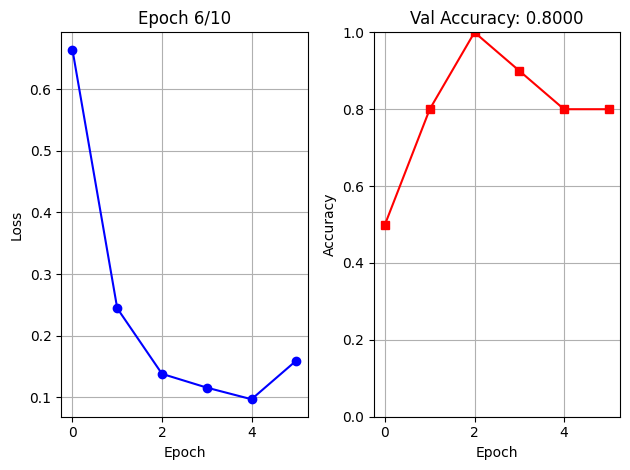

[Epoch 6/10] train_loss=0.1595  val_acc=0.8000


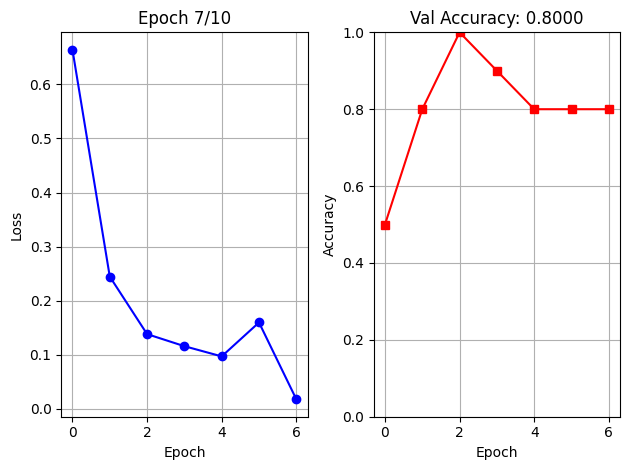

[Epoch 7/10] train_loss=0.0174  val_acc=0.8000


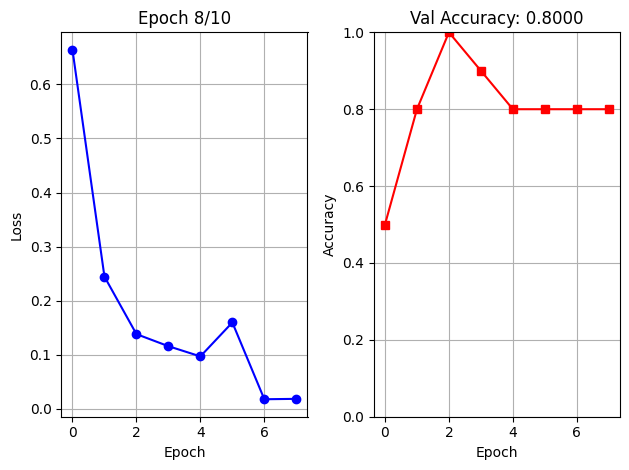

[Epoch 8/10] train_loss=0.0181  val_acc=0.8000


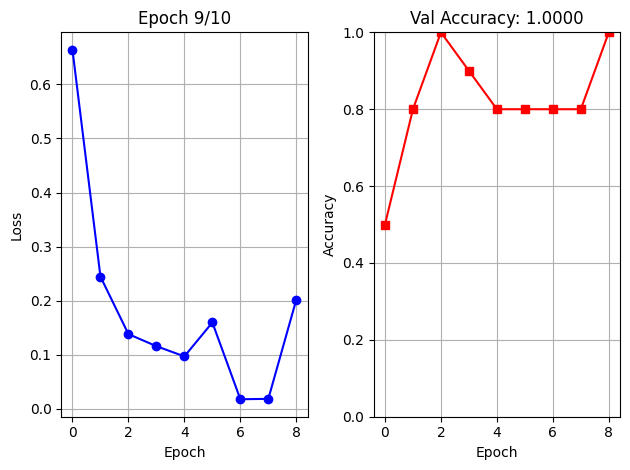

[Epoch 9/10] train_loss=0.2017  val_acc=1.0000


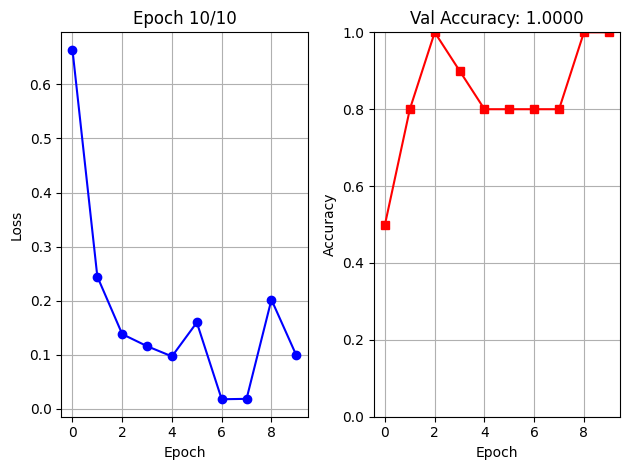

[Epoch 10/10] train_loss=0.0988  val_acc=1.0000


In [ ]:
start_time = time.time()
history = train_eval(model1, train_loader, val_loader, EPOCHS, LR)
train_runtime = time.time() - start_time

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

27.32571268081665 секунд затрачено на обучение.
0.46 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 0.281 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.219 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 1.906 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 1.486 %.


In [ ]:
# Итоговая оценка на тесте
model1.eval()
preds, labs = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model1(x).argmax(1).cpu().tolist()
        preds += out; labs += y.tolist()
acc_test = accuracy_score(labs, preds)
prf = precision_recall_fscore_support(labs, preds, average='binary')
cm  = confusion_matrix(labs, preds)
print(f"\nTEST ACC: {acc_test:.4f}")
print(f"Precision={prf[0]:.4f}, Recall={prf[1]:.4f}, F1={prf[2]:.4f}")
print("Confusion matrix:\n", cm)


TEST ACC: 0.9500
Precision=0.9500, Recall=0.9500, F1=0.9500
Confusion matrix:
 [[19  1]
 [ 1 19]]


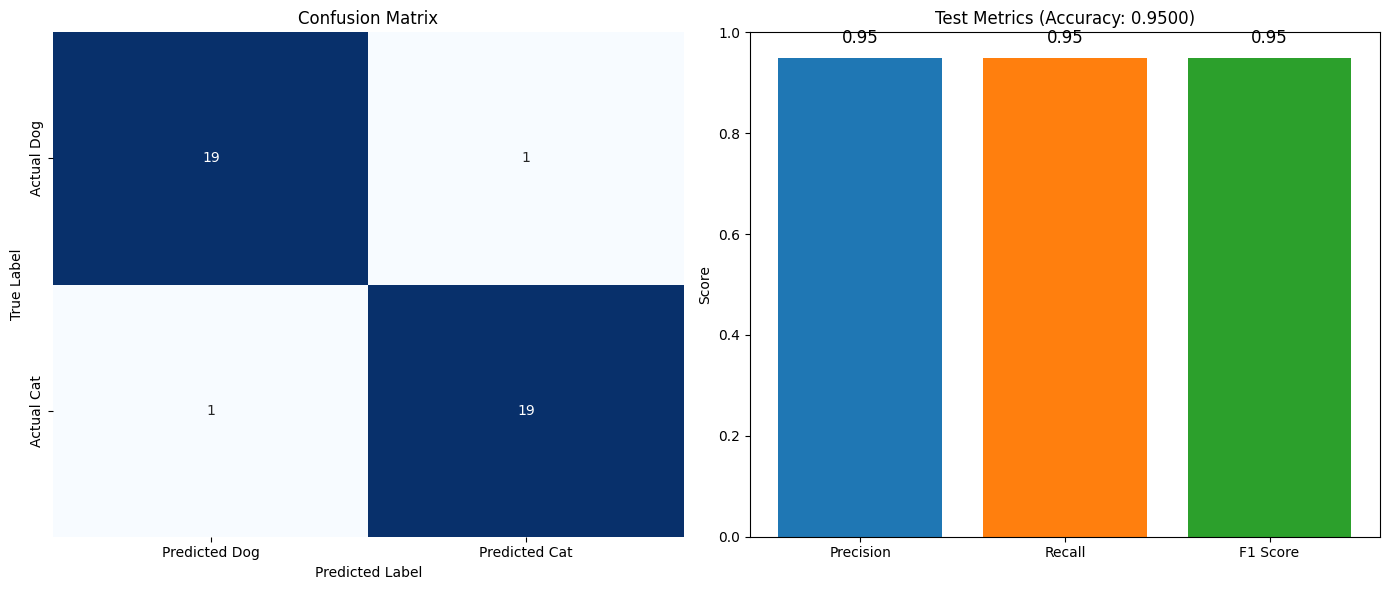

In [ ]:
def plot_test_metrics(cm, prf, acc_test):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Dog', 'Predicted Cat'],
                yticklabels=['Actual Dog', 'Actual Cat'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = prf[:3]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1)
    plt.title(f'Test Metrics (Accuracy: {acc_test:.4f})')
    plt.ylabel('Score')
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 0.02, f'{val:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_test_metrics(cm, prf, acc_test)

Отличные метрики, попробуем обучится на других класах (звуки пылсеоса и самолете, довольно сложная задача)

In [ ]:
CLASSES = ['vacuum_cleaner', 'airplane']

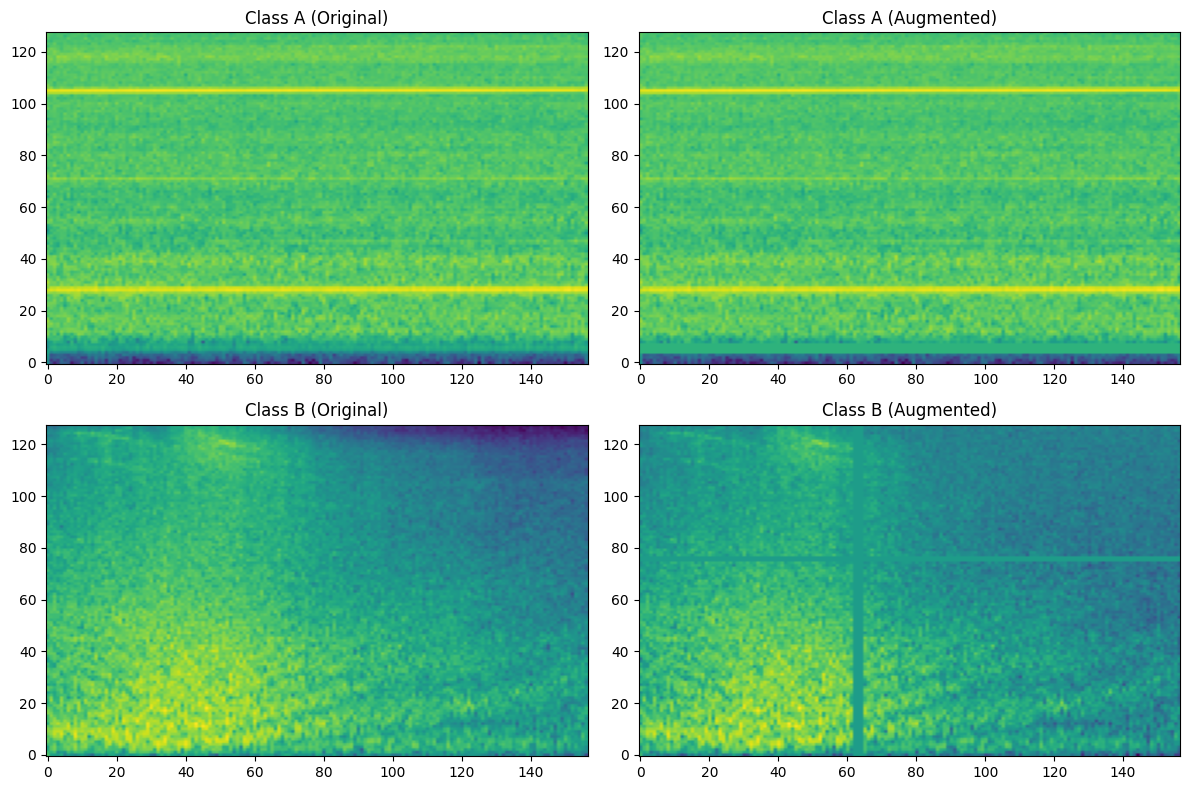

Class A Original Audio:


Class A Augmented Audio:



Class B Original Audio:


Class B Augmented Audio:


In [ ]:
class_a_audio = "/content/ESC-50/audio/5-263902-A-36.wav"
class_b_audio = "/content/ESC-50/audio/5-251962-A-47.wav"
compare_two_classes_wav(class_a_audio, class_b_audio)

In [ ]:
meta = pd.read_csv('ESC-50/meta/esc50.csv')
meta = meta[meta['category'].isin(CLASSES)]
files_by_class = {
    cls: meta[meta['category'] == cls]['filename'].tolist()
    for cls in CLASSES
}

train_files = {}
val_files   = {}
test_files  = {}
for cls, flist in files_by_class.items():
    random.shuffle(flist)
    train_files[cls] = flist[:NUM_TRAIN]
    val_files[cls]   = flist[NUM_TRAIN:NUM_TRAIN + NUM_VAL]
    test_files[cls]  = flist[NUM_TRAIN + NUM_VAL:]

In [ ]:
def get_train_files_dimensionality(train_files):
  num_classes = len(train_files)
  files_per_class = len(train_files[list(train_files.keys())[0]])
  total_files = num_classes * files_per_class
  return num_classes, files_per_class, total_files


print("\nTrain:")
num_classes, files_per_class, total_files = get_train_files_dimensionality(train_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")

print("\nValidation")
num_classes, files_per_class, total_files = get_train_files_dimensionality(val_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")

print("\nTest")
num_classes, files_per_class, total_files = get_train_files_dimensionality(test_files)
print(f"Number of classes: {num_classes}")
print(f"Number of files per class: {files_per_class}")
print(f"Total number of training files: {total_files}")


Train:
Number of classes: 2
Number of files per class: 15
Total number of training files: 30

Validation
Number of classes: 2
Number of files per class: 5
Total number of training files: 10

Test
Number of classes: 2
Number of files per class: 20
Total number of training files: 40


In [ ]:
train_ds = ESC50Split(
    train_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=spec_augment,
    target_size=TARGET_SIZE
)

val_ds = ESC50Split(
    val_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=None,
    target_size=None
)
test_ds = ESC50Split(
    test_files,
    audio_dir='ESC-50/audio',
    spec_transform=spec_transform,
    spec_augment=None,
    target_size=None
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Количество файлов в train_ds:", len(train_ds))
print("Количество файлов в val_ds:", len(val_ds))
print("Количество файлов в test_ds:", len(test_ds))

Количество файлов в train_ds: 100
Количество файлов в val_ds: 10
Количество файлов в test_ds: 40


In [ ]:
model1 = resnet18(pretrained=True)
model1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model1.fc = nn.Linear(model1.fc.in_features, len(CLASSES))
model1 = model1.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.281 ГБ памяти зарезервировано.


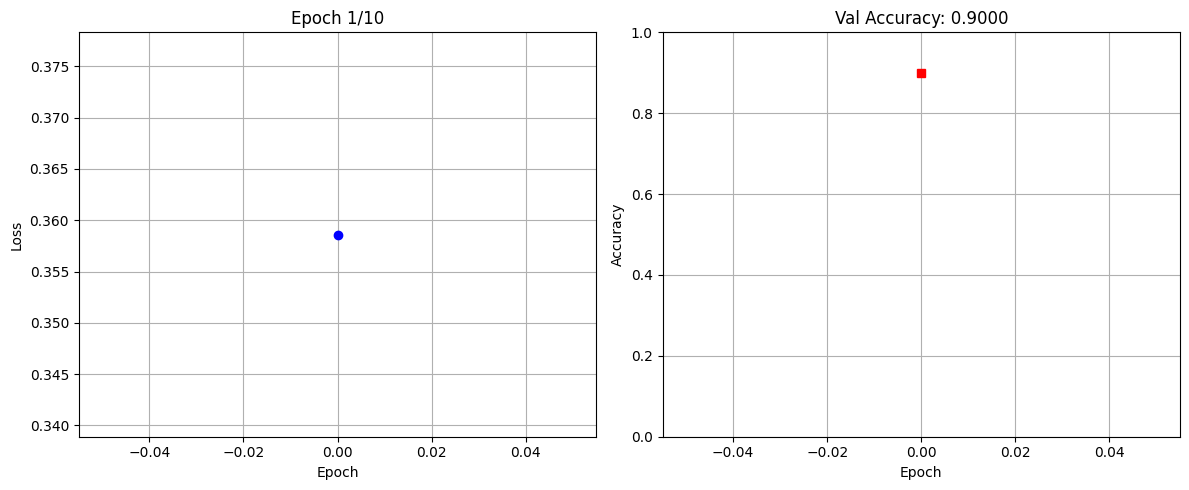

[Epoch 1/10] train_loss=0.3586  val_acc=0.9000


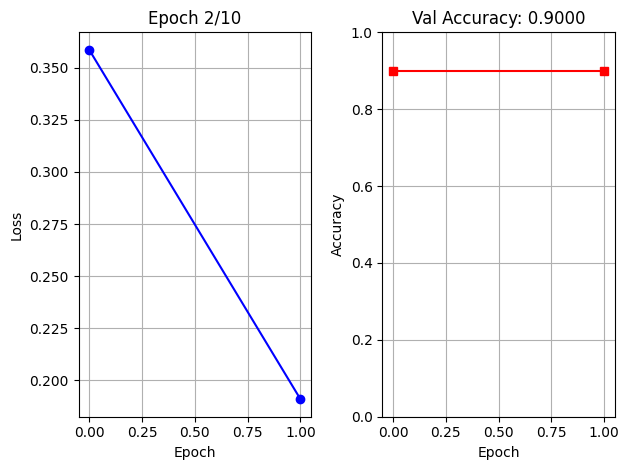

[Epoch 2/10] train_loss=0.1909  val_acc=0.9000


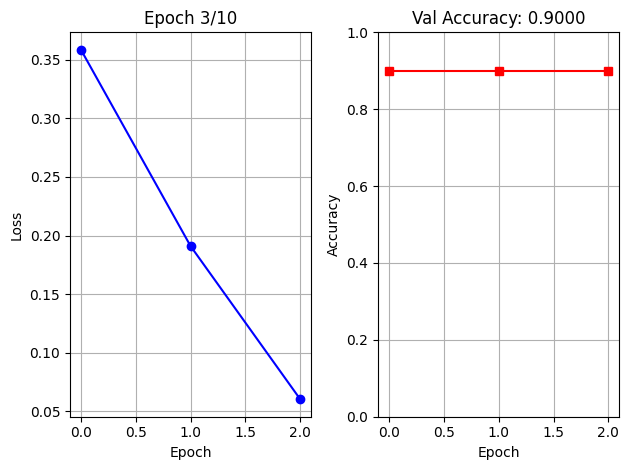

[Epoch 3/10] train_loss=0.0602  val_acc=0.9000


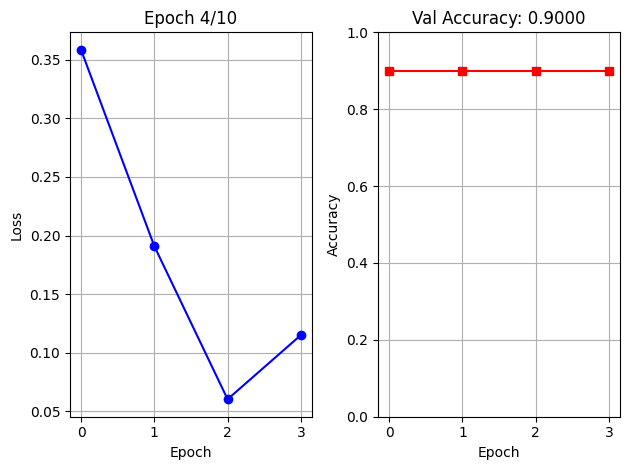

[Epoch 4/10] train_loss=0.1150  val_acc=0.9000


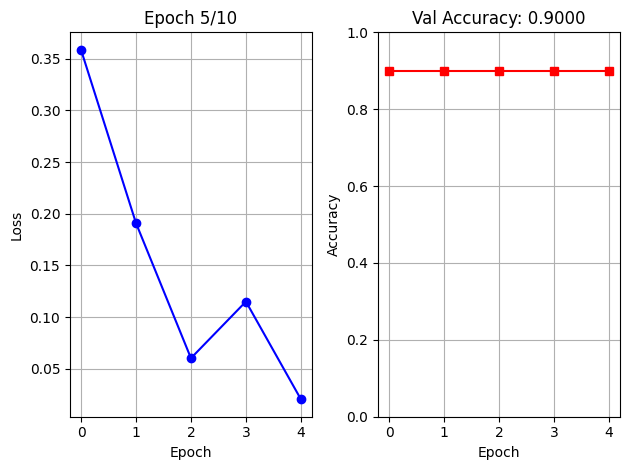

[Epoch 5/10] train_loss=0.0205  val_acc=0.9000


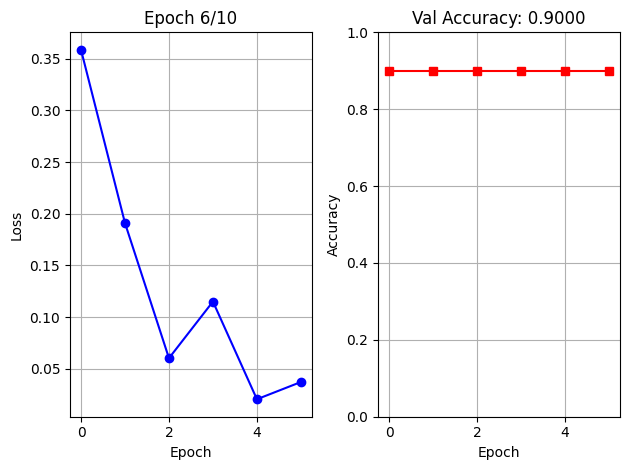

[Epoch 6/10] train_loss=0.0372  val_acc=0.9000


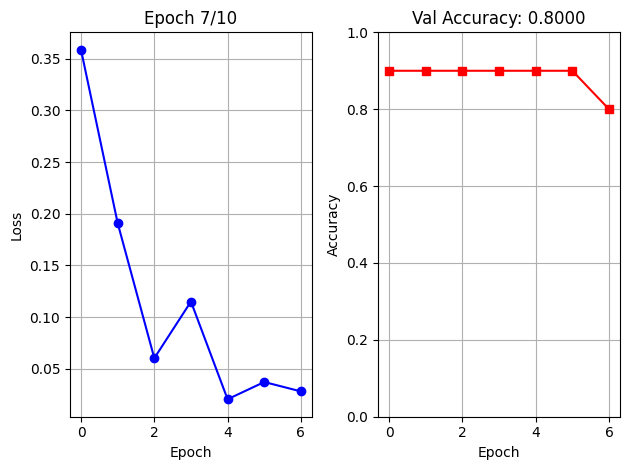

[Epoch 7/10] train_loss=0.0281  val_acc=0.8000


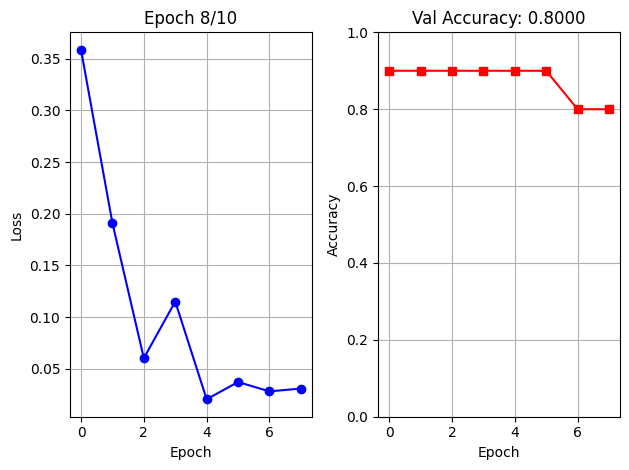

[Epoch 8/10] train_loss=0.0308  val_acc=0.8000


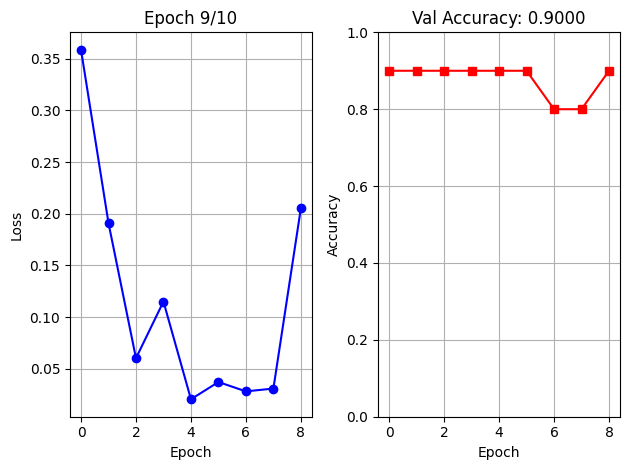

[Epoch 9/10] train_loss=0.2053  val_acc=0.9000


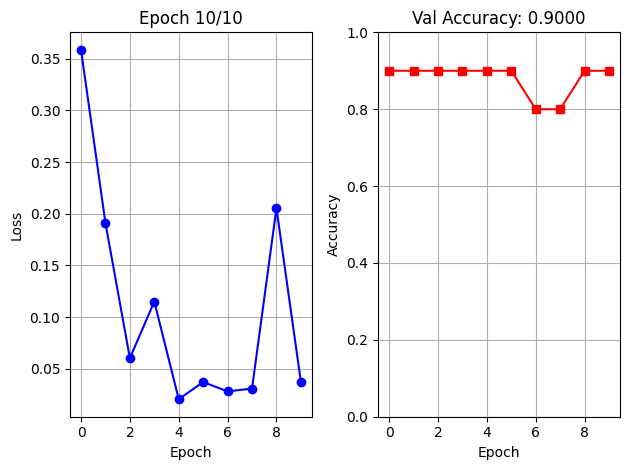

[Epoch 10/10] train_loss=0.0374  val_acc=0.9000


In [ ]:
start_time = time.time()
history = train_eval(model1, train_loader, val_loader, EPOCHS, LR)
train_runtime = time.time() - start_time

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

27.085803031921387 секунд затрачено на обучение.
0.45 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 0.283 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.002 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 1.92 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.014 %.


In [ ]:
# Итоговая оценка на тесте
model1.eval()
preds, labs = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model1(x).argmax(1).cpu().tolist()
        preds += out; labs += y.tolist()
acc_test = accuracy_score(labs, preds)
prf = precision_recall_fscore_support(labs, preds, average='binary')
cm  = confusion_matrix(labs, preds)
print(f"\nTEST ACC: {acc_test:.4f}")
print(f"Precision={prf[0]:.4f}, Recall={prf[1]:.4f}, F1={prf[2]:.4f}")
print("Confusion matrix:\n", cm)


TEST ACC: 0.9000
Precision=0.8636, Recall=0.9500, F1=0.9048
Confusion matrix:
 [[17  3]
 [ 1 19]]


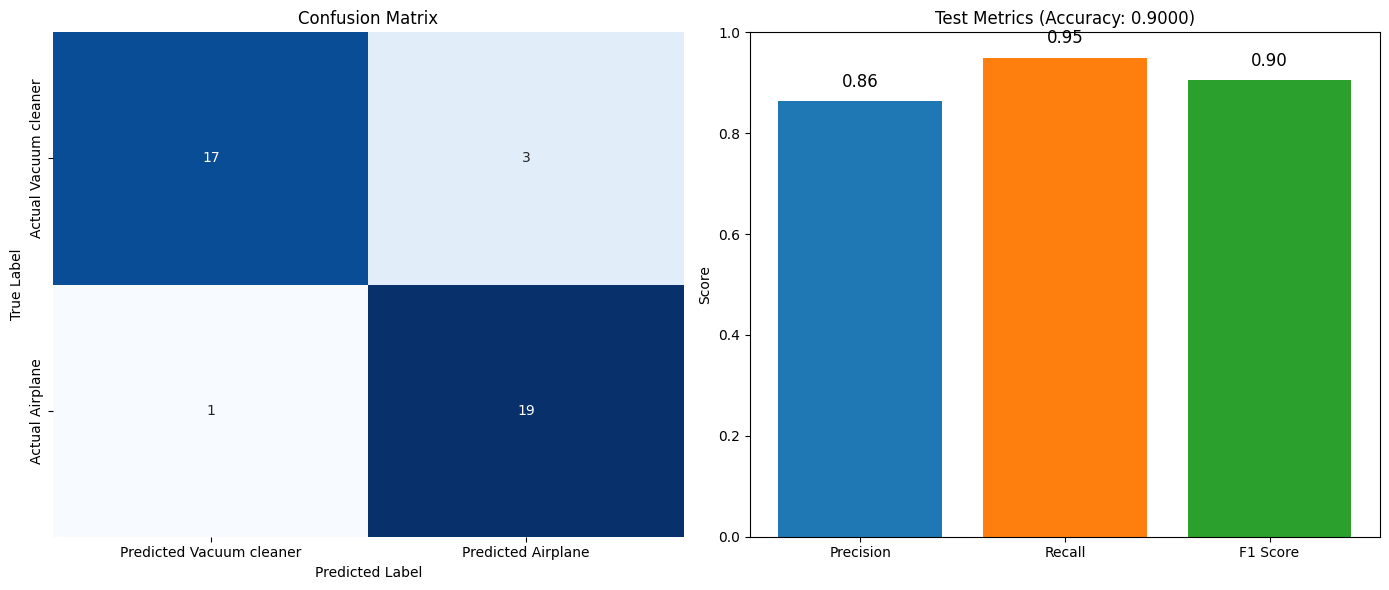

In [ ]:
def plot_test_metrics(cm, prf, acc_test):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Vacuum cleaner', 'Predicted Airplane'],
                yticklabels=['Actual Vacuum cleaner', 'Actual Airplane'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = prf[:3]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1)
    plt.title(f'Test Metrics (Accuracy: {acc_test:.4f})')
    plt.ylabel('Score')
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 0.02, f'{val:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_test_metrics(cm, prf, acc_test)

Реузультаты немного хуже, однако даже на таких сложных классах видно, что сеть смогла выучить какие-то признаки.

## Подход 2: PANNs-эмбеддинги + MLP
### Используем предобученные аудио-эмбеддинги из PANNs (Pre-trained Audio Neural Networks)


Попрбуем сразу же на них следующий подход

In [ ]:
from panns_inference import AudioTagging
audio_tagger = AudioTagging(checkpoint_path=None, device='cuda')

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [ ]:
class PANNsEmbedDataset(Dataset):
    def __init__(self, files_dict, audio_dir, spec_augment=None, target_size=None):
        """
        files_dict: {class_name: [fname, ...]}
        spec_augment: dict или None - аугментации для аудио
        target_size: int or None - для train: увеличить до target_size примеров на класс
        """
        self.audio_dir = audio_dir
        self.spec_augment = spec_augment
        self.target_size = target_size
        self.audio_tagger = audio_tagger
        self.samples = []

        for cls, flist in files_dict.items():
            label = CLASSES.index(cls)
            if target_size is not None:
                base = random.sample(flist, min(len(flist), NUM_TRAIN))
                for i in range(target_size):
                    fname = base[i % len(base)]
                    self.samples.append((fname, label))
            else:
                for fname in flist:
                    self.samples.append((fname, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, label = self.samples[idx]
        path = os.path.join(self.audio_dir, fname)
        wav, sr = torchaudio.load(path)
        wav = prepare_audio(wav, sr)

        if self.spec_augment and "waveform" in self.spec_augment:
            wav = self.spec_augment["waveform"](wav)

        wav_np = wav.squeeze().cpu().numpy()

        with torch.no_grad():
            clipwise_out, emb = audio_tagger.inference(wav_np[None, :])

        emb = torch.from_numpy(emb).squeeze(0)

        return emb, label

In [ ]:
def train_eval_panns(model, train_loader, val_loader, epochs, lr, plot_every=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_acc': []}

    plt.figure(figsize=(12, 5))

    for ep in range(epochs):
        model.train()
        total_loss, total_samples = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        train_loss = total_loss / total_samples
        history['train_loss'].append(train_loss)

        model.eval()
        preds, labs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE)
                out = model(x).argmax(1).cpu().tolist()
                preds += out
                labs += y.tolist()

        val_acc = accuracy_score(labs, preds)
        history['val_acc'].append(val_acc)

        if (ep+1) % plot_every == 0 or ep == 0:
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], 'b-o', label='Train Loss')
            plt.title(f'Epoch {ep+1}/{epochs}')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            plt.plot(history['val_acc'], 'r-s', label='Val Accuracy')
            plt.title(f'Val Accuracy: {val_acc:.4f}')
            plt.ylim(0, 1.0)
            plt.grid(True)

            plt.tight_layout()
            plt.show()
            plt.pause(0.1)

        print(f"[Epoch {ep+1}/{epochs}] "
              f"train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")

    return history

In [ ]:
train_ds2 = PANNsEmbedDataset(
    train_files,
    audio_dir='ESC-50/audio',
    spec_augment=spec_augment,
    target_size=TARGET_SIZE
)

val_ds2 = PANNsEmbedDataset(
    val_files,
    audio_dir='ESC-50/audio',
    spec_augment=None,
    target_size=None
)

test_ds2 = PANNsEmbedDataset(
    test_files,
    audio_dir='ESC-50/audio',
    spec_augment=None,
    target_size=None
)

train_loader2 = DataLoader(train_ds2, batch_size=BATCH_SIZE, shuffle=True)
val_loader2 = DataLoader(val_ds2, batch_size=BATCH_SIZE, shuffle=False)
test_loader2 = DataLoader(test_ds2, batch_size=BATCH_SIZE, shuffle=False)

print("Количество файлов в train_ds2:", len(train_ds2))
print("Количество файлов в val_ds2:", len(val_ds2))
print("Количество файлов в test_ds2:", len(test_ds2))

Количество файлов в train_ds2: 100
Количество файлов в val_ds2: 10
Количество файлов в test_ds2: 40


In [ ]:
sample_emb, _ = train_ds2[0]
embedding_dim = sample_emb.shape[0]
print(f"Размер эмбеддинга PANNs: {embedding_dim}")

model2 = nn.Sequential(
    nn.Linear(embedding_dim, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(CLASSES))
).to(DEVICE)

Размер эмбеддинга PANNs: 2048


In [ ]:
model2 = nn.Sequential(
    nn.Linear(embedding_dim, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(CLASSES))
).to(DEVICE)

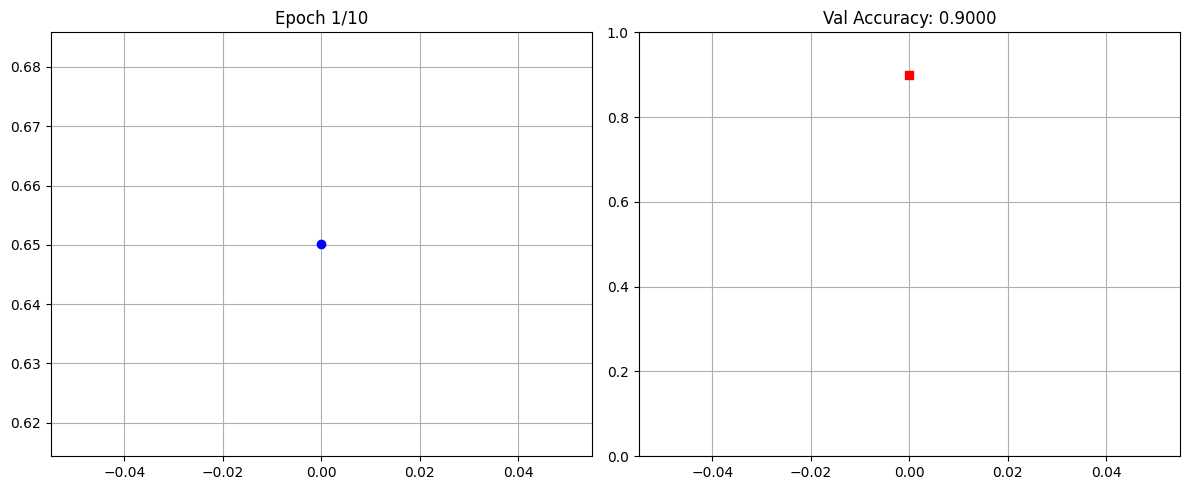

[Epoch 1/10] train_loss=0.6501  val_acc=0.9000


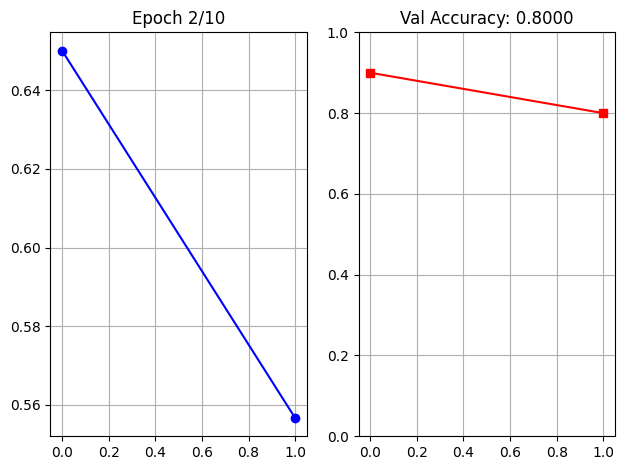

[Epoch 2/10] train_loss=0.5567  val_acc=0.8000


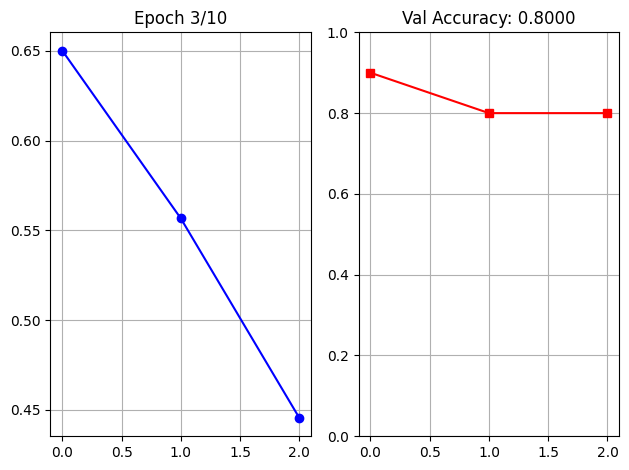

[Epoch 3/10] train_loss=0.4455  val_acc=0.8000


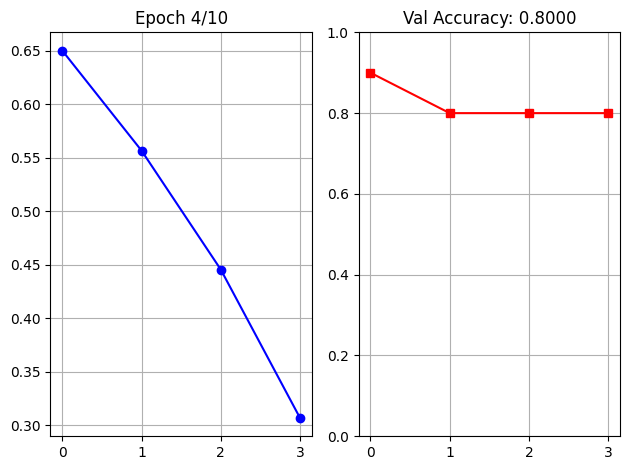

[Epoch 4/10] train_loss=0.3069  val_acc=0.8000


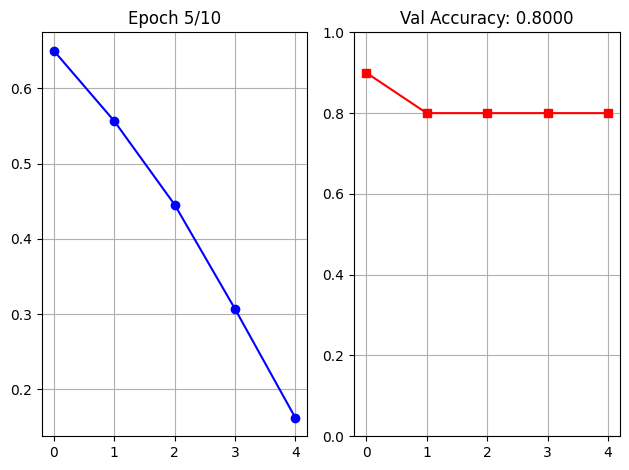

[Epoch 5/10] train_loss=0.1621  val_acc=0.8000


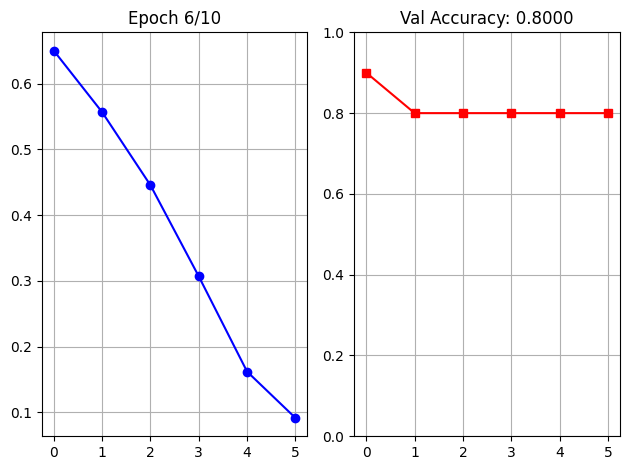

[Epoch 6/10] train_loss=0.0917  val_acc=0.8000


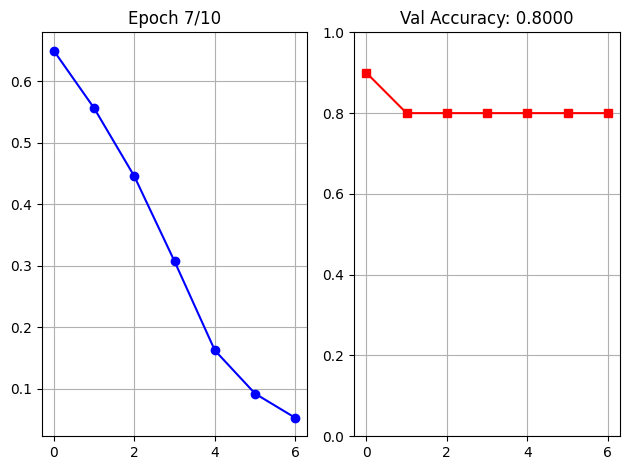

[Epoch 7/10] train_loss=0.0522  val_acc=0.8000


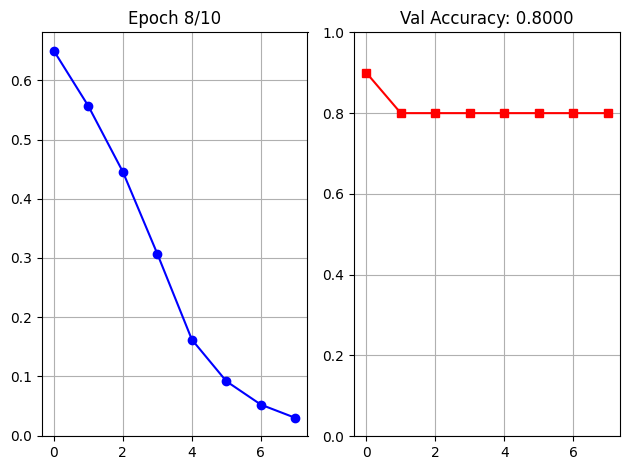

[Epoch 8/10] train_loss=0.0298  val_acc=0.8000


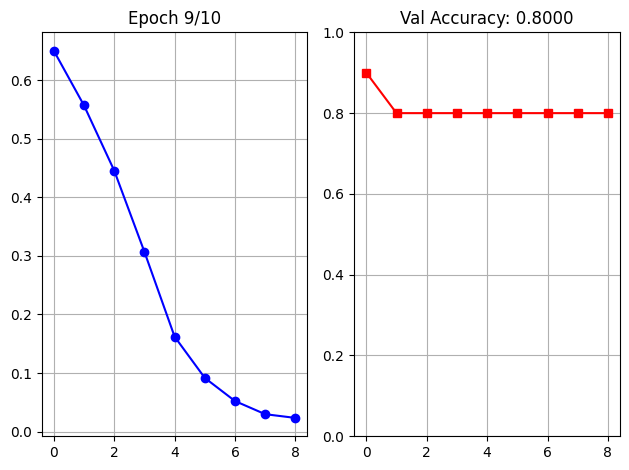

[Epoch 9/10] train_loss=0.0234  val_acc=0.8000


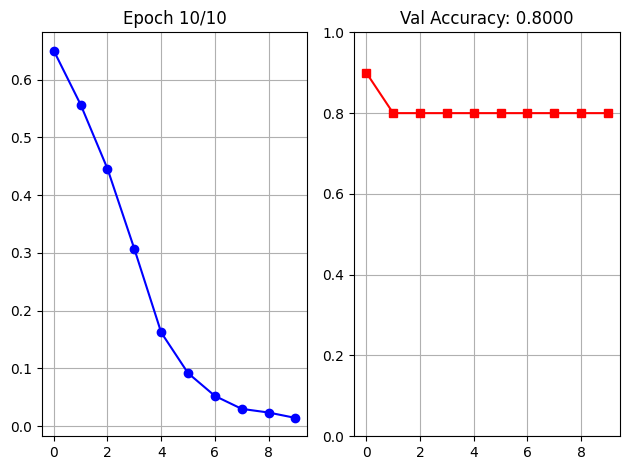

[Epoch 10/10] train_loss=0.0141  val_acc=0.8000


In [ ]:
start_time = time.time()
history2 = train_eval_panns(model2, train_loader2, val_loader2, EPOCHS, LR)
train_runtime = time.time() - start_time

In [ ]:
# Выводим статистику времени
print(f"{train_runtime} секунд затрачено на обучение.")
print(f"{round(train_runtime/60, 2)} минут затрачено на обучение.")

35.00990867614746 секунд затрачено на обучение.
0.58 минут затрачено на обучение.


In [ ]:
model2.eval()
preds2, labs2 = [], []
with torch.no_grad():
    for x, y in test_loader2:
        x = x.to(DEVICE)
        out = model2(x).argmax(1).cpu().tolist()
        preds2 += out
        labs2 += y.tolist()

acc_test2 = accuracy_score(labs2, preds2)
prf2 = precision_recall_fscore_support(labs2, preds2, average='binary')
cm2 = confusion_matrix(labs2, preds2)

print(f"\nTEST ACC (PANNs): {acc_test2:.4f}")
print(f"Precision={prf2[0]:.4f}, Recall={prf2[1]:.4f}, F1={prf2[2]:.4f}")
print("Confusion matrix:\n", cm2)


TEST ACC (PANNs): 1.0000
Precision=1.0000, Recall=1.0000, F1=1.0000
Confusion matrix:
 [[20  0]
 [ 0 20]]


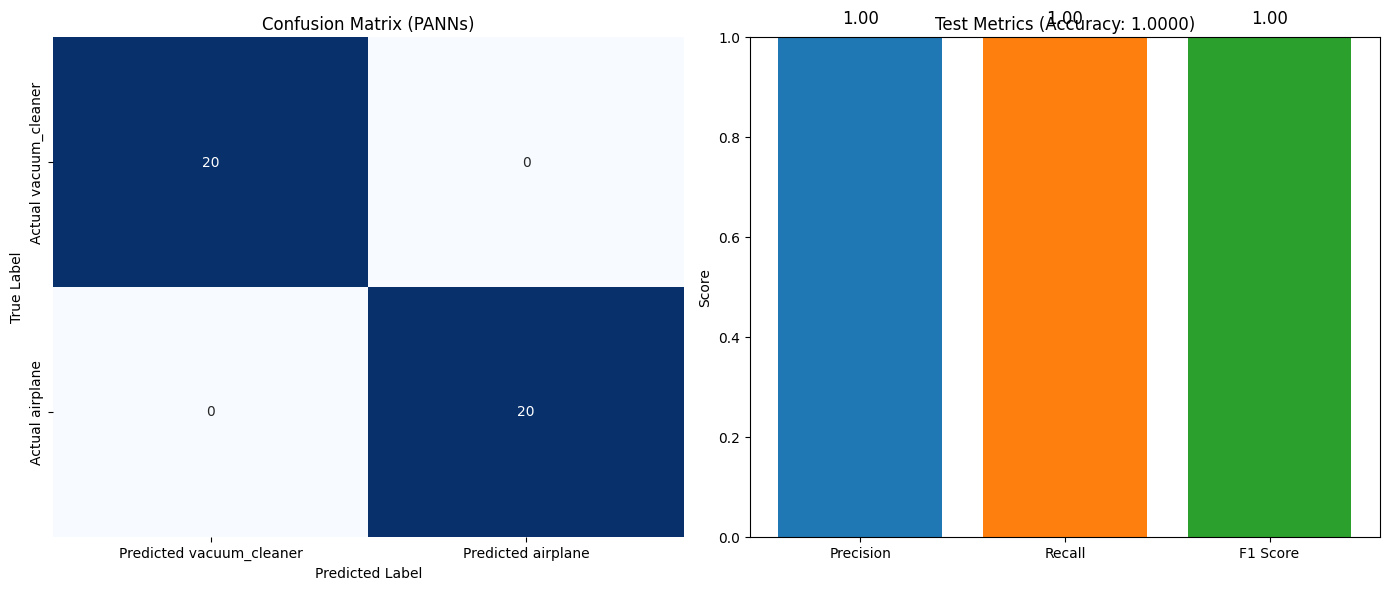

In [ ]:
def plot_test_metrics_panns(cm, prf, acc_test):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Predicted {CLASSES[0]}', f'Predicted {CLASSES[1]}'],
                yticklabels=[f'Actual {CLASSES[0]}', f'Actual {CLASSES[1]}'])
    plt.title('Confusion Matrix (PANNs)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = prf[:3]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1)
    plt.title(f'Test Metrics (Accuracy: {acc_test:.4f})')
    plt.ylabel('Score')
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, val + 0.02, f'{val:.2f}',
                 ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_test_metrics_panns(cm2, prf2, acc_test2)

100% predict, однако валидация чуть хуже

## Подход 3: AST (Audio Spectrogram Transformer)



Продолжим также на этих же классах

In [ ]:
from transformers import ASTFeatureExtractor, ASTForAudioClassification
import audiomentations as A

In [ ]:
ast_augment = A.Compose([
    A.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    A.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
])


In [ ]:
class ASTDataset(Dataset):
    def __init__(self, files_dict, audio_dir, augment=False):
        self.audio_dir = audio_dir
        self.augment = augment
        self.feature_extractor = ASTFeatureExtractor.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
        self.samples = []

        for cls, flist in files_dict.items():
            label = CLASSES.index(cls)
            for fname in flist:
                self.samples.append((fname, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname, label = self.samples[idx]
        path = os.path.join(self.audio_dir, fname)
        wav, sr = torchaudio.load(path)
        wav = prepare_audio(wav, sr).squeeze().numpy()

        if self.augment:
            wav = ast_augment(samples=wav, sample_rate=SR)

        inputs = self.feature_extractor(
            wav,
            sampling_rate=SR,
            return_tensors="pt",
            padding="max_length",
            max_length=SAMPLES
        )

        return {k: v.squeeze(0) for k, v in inputs.items()}, label

In [ ]:
# Создание датасетов и загрузчиков
train_ds3 = ASTDataset(train_files, 'ESC-50/audio', augment=True)
val_ds3 = ASTDataset(val_files, 'ESC-50/audio')
test_ds3 = ASTDataset(test_files, 'ESC-50/audio')

train_loader3 = DataLoader(train_ds3, batch_size=BATCH_SIZE, shuffle=True)
val_loader3 = DataLoader(val_ds3, batch_size=BATCH_SIZE)
test_loader3 = DataLoader(test_ds3, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
model3 = ASTForAudioClassification.from_pretrained(
    'MIT/ast-finetuned-audioset-10-10-0.4593',
    num_labels=len(CLASSES),
    ignore_mismatched_sizes=True
).to(DEVICE)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_eval_ast(model, train_loader, val_loader, epochs, lr):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_acc': []}

    plt.figure(figsize=(12, 5))

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        model.eval()
        preds, labs = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                outputs = model(**inputs).logits.argmax(1).cpu().tolist()
                preds += outputs
                labs += labels.tolist()

        train_loss = total_loss / len(train_loader)
        val_acc = accuracy_score(labs, preds)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)

        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], 'b-o', label='Train Loss')
        plt.title(f'Epoch {ep+1}/{epochs}')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history['val_acc'], 'r-s', label='Val Accuracy')
        plt.title(f'Val Accuracy: {val_acc:.4f}')
        plt.ylim(0, 1.0)
        plt.grid(True)

        plt.tight_layout()
        plt.show()
        plt.pause(0.1)

        print(f"[Epoch {ep+1}/{epochs}] train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")

    return history

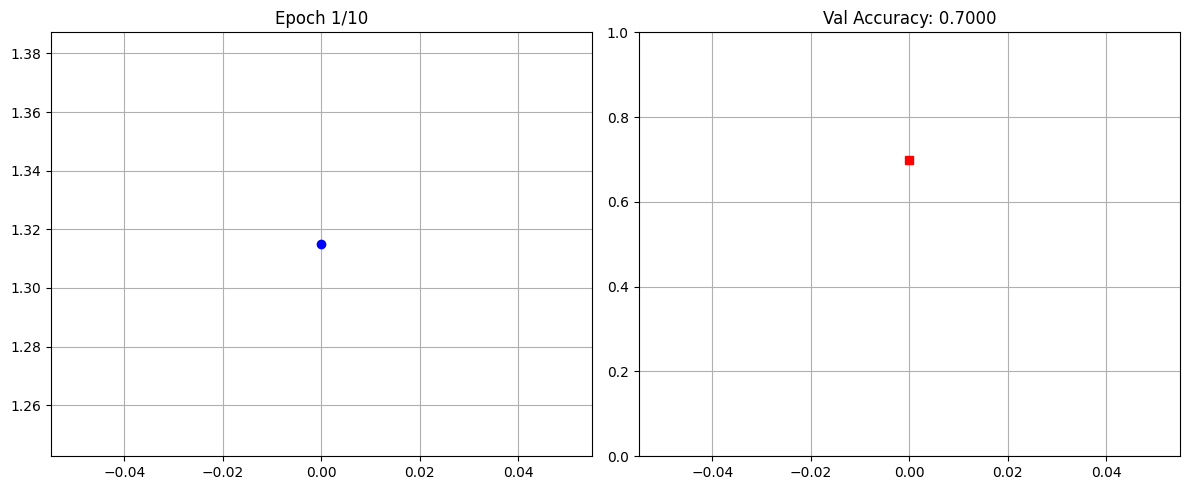

[Epoch 1/10] train_loss=1.3149  val_acc=0.7000


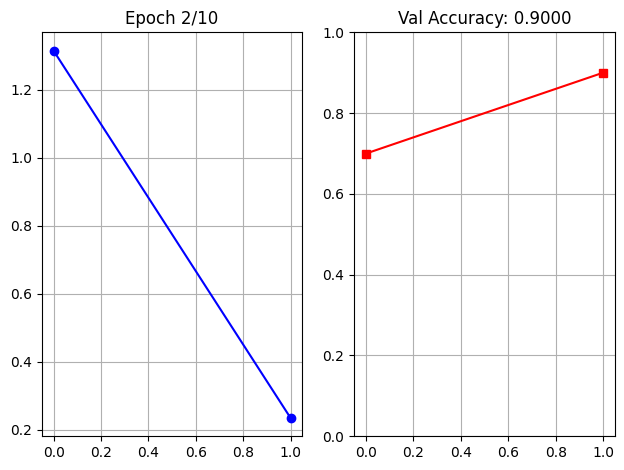

[Epoch 2/10] train_loss=0.2342  val_acc=0.9000


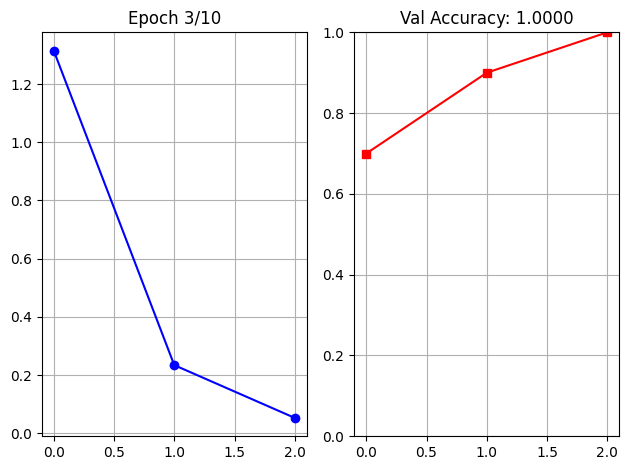

[Epoch 3/10] train_loss=0.0527  val_acc=1.0000


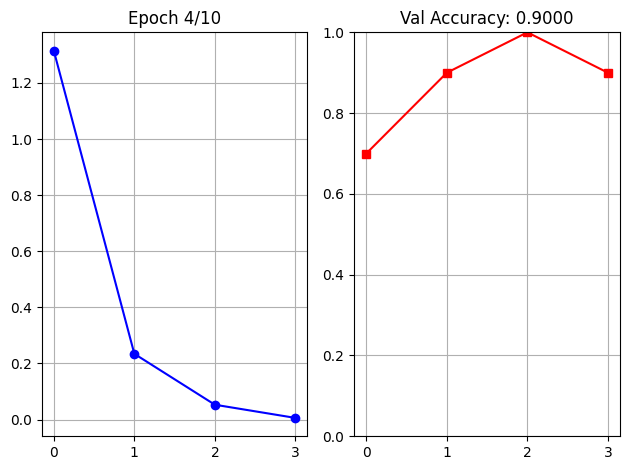

[Epoch 4/10] train_loss=0.0057  val_acc=0.9000


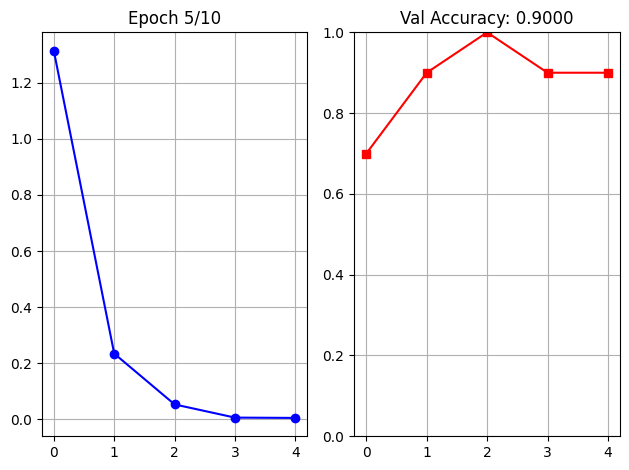

[Epoch 5/10] train_loss=0.0046  val_acc=0.9000


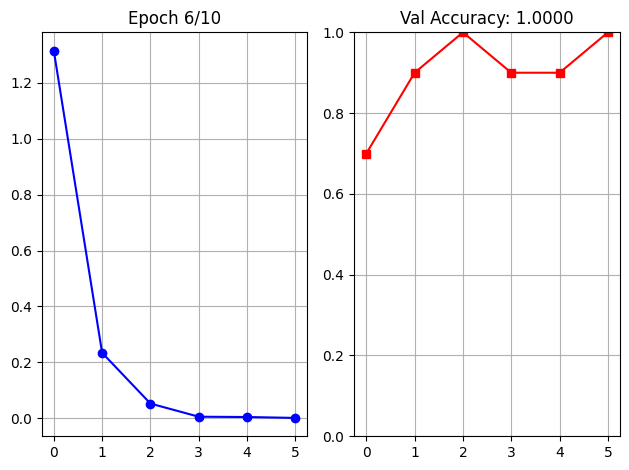

[Epoch 6/10] train_loss=0.0014  val_acc=1.0000


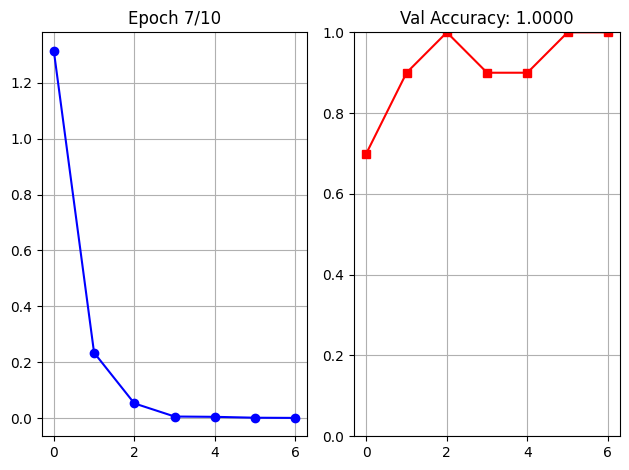

[Epoch 7/10] train_loss=0.0007  val_acc=1.0000


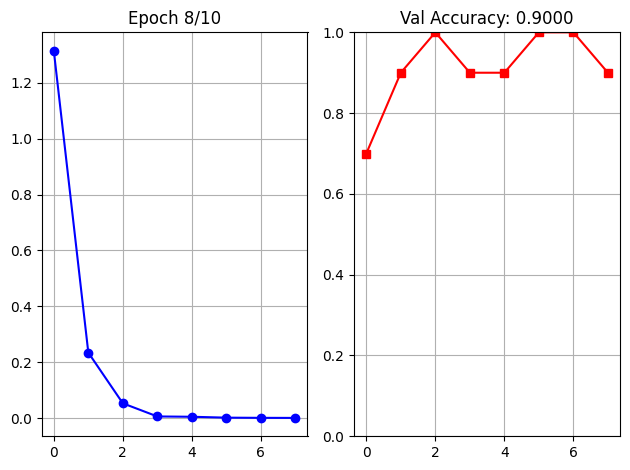

[Epoch 8/10] train_loss=0.0004  val_acc=0.9000


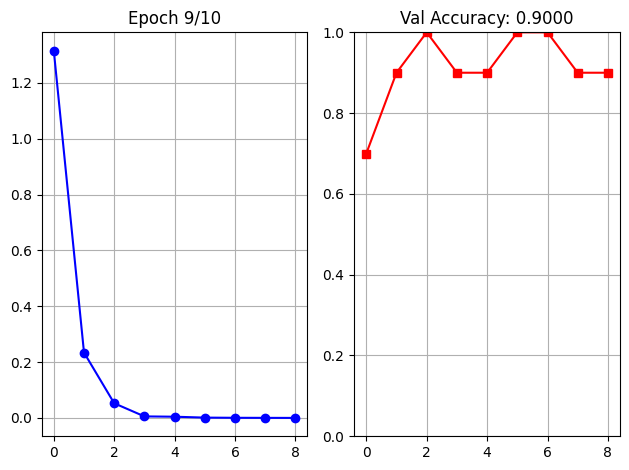

[Epoch 9/10] train_loss=0.0003  val_acc=0.9000


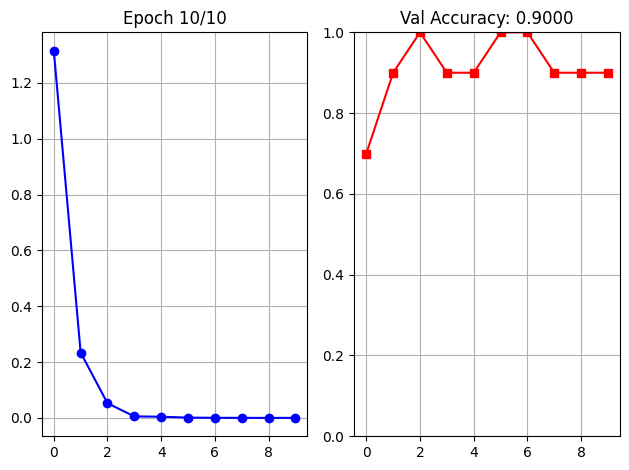

[Epoch 10/10] train_loss=0.0004  val_acc=0.9000


In [ ]:
start_time = time.time()
history3 = train_eval_ast(model3, train_loader3, val_loader3, EPOCHS, LR)
train_runtime = time.time() - start_time

In [ ]:
model3.eval()
preds3, labs3 = [], []
with torch.no_grad():
    for inputs, labels in test_loader3:
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = model3(**inputs).logits.argmax(1).cpu().tolist()
        preds3 += outputs
        labs3 += labels.tolist()

acc_test3 = accuracy_score(labs3, preds3)
prf3 = precision_recall_fscore_support(labs3, preds3, average='binary')
cm3 = confusion_matrix(labs3, preds3)

print(f"\nTEST ACC (AST): {acc_test3:.4f}")
print(f"Precision={prf3[0]:.4f}, Recall={prf3[1]:.4f}, F1={prf3[2]:.4f}")
print("Confusion matrix:\n", cm3)


TEST ACC (AST): 0.9750
Precision=1.0000, Recall=0.9500, F1=0.9744
Confusion matrix:
 [[20  0]
 [ 1 19]]


In [ ]:
# Выводим статистику времени
print(f"{train_runtime} секунд затрачено на обучение.")
print(f"{round(train_runtime/60, 2)} минут затрачено на обучение.")

111.81748652458191 секунд затрачено на обучение.
1.86 минут затрачено на обучение.


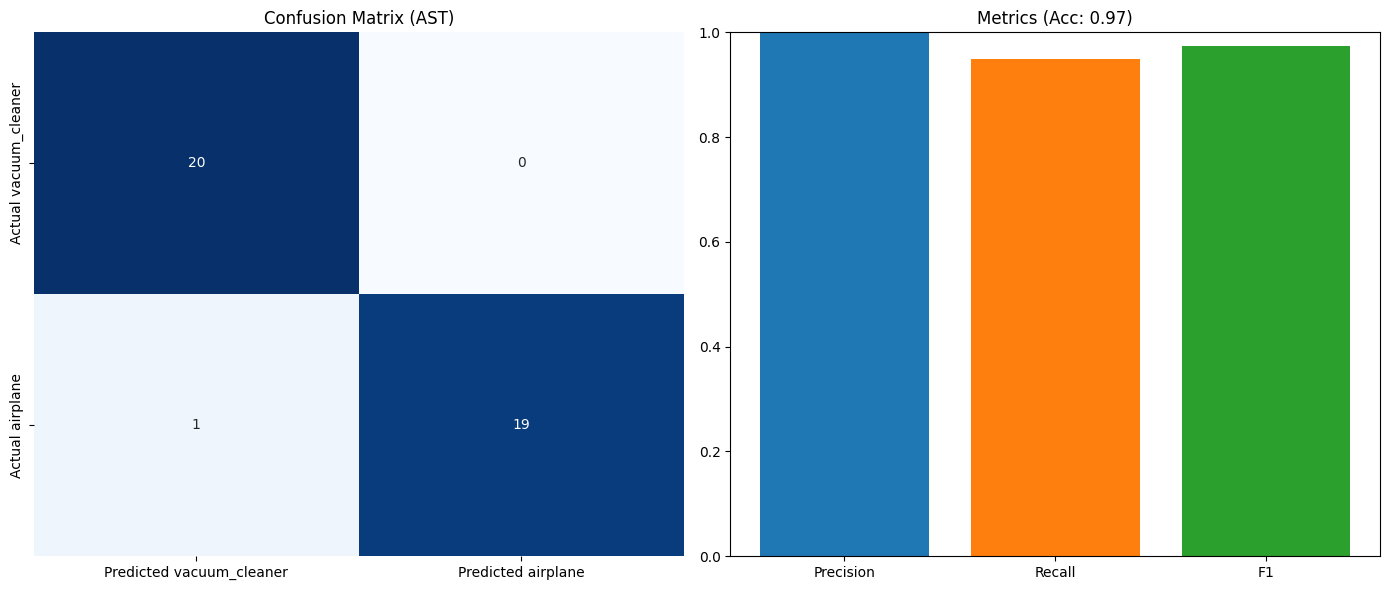

In [ ]:
def plot_test_metrics_ast(cm, prf, acc_test):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Predicted {c}' for c in CLASSES],
                yticklabels=[f'Actual {c}' for c in CLASSES])
    plt.title('Confusion Matrix (AST)')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1']
    plt.bar(metrics, prf[:3], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.ylim(0, 1)
    plt.title(f'Metrics (Acc: {acc_test:.2f})')

    plt.tight_layout()
    plt.show()

plot_test_metrics_ast(cm3, prf3, acc_test3)